<a href="https://colab.research.google.com/github/SNEHA-67/comp215/blob/main/labs/lab07_cellular_automata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 7
-----------------------------------------------
#### Name: Sneha & Manmeet Sharma
#### Date: 05-03-2025

This lab exercise is an introduction to the elementary [Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton) studied by [Stephen Wolfram](https://en.wikipedia.org/wiki/Stephen_Wolfram#Complex_systems_and_cellular_automata).

**New Python concepts**:
  * **[NumPy](https://numpy.org)** is an open-source scientific computing package.  We will be using numpy for the remainder of the term.
  * 1D and 2D [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) -  a rectangular grid with efficient matrix operations.

**New Computation concepts**:
  * **bit sequence** (a.k.a. binary number) - using a sequence of 0's and 1's to efficiently represent a data structure and processes.

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Elementary Cellular Automata
Both the textbook and our week 7 notebooks develop some fundamental operations for simulating Elementary CA.  The sliding dot product algorithm in `rule_indexes` is implemented with [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html).  It's behaviour is identical to the derivation from class.

#### Notes
* we use `np.pad(array, 1, mode='wrap')` to pad state vector with 1 extra value at both ends, equal to the last value at the opposing end of the vector.  This strategy avoids [edge effects](https://en.wikipedia.org/wiki/Boundary_problem_(spatial_analysis)#Types_and_examples).
* since the rule is an `np.array`, we use "vector indexing" here to index a whole row at once:  `next_row=rule[indexes]`  See `foundations/numpy_1D_arrays` for details.


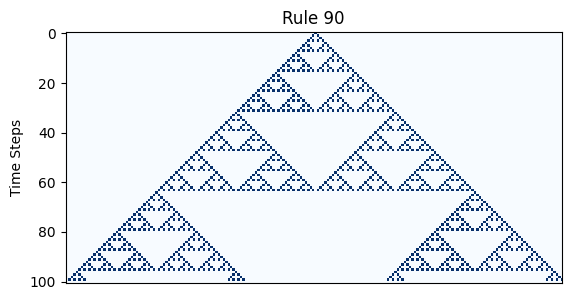

In [10]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighbourhood in the CA state vector. """
    # numpy's version of the "sliding dot product" algorithm;  "pad" ends of state array with extra 0 cell to mitigate edge effects
    return np.correlate(np.pad(state, 1, mode='constant'), POWERS_OF_2, mode='valid')

assert all( rule_indexes(np.array([1,1,0,0,1,0,0,0])) == [3, 6, 4, 1, 2, 4, 0, 0] )

def transition(state, rule):
    """ Return the vector resulting from a transition of given CA state under the given 8-bit rule """
    indexes = rule_indexes(state)
    return np.array(rule[indexes])  # "vector indexing" replaces: [rule[i] for i in indexes]

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), np.array(rule_110)) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )


def single_centre_array(n_cells):
    """ Return a binary 1D array with given number of cells, all zeros except a single 1 in the centre cell """
    array = np.zeros(n_cells, dtype=np.uint8)
    array[n_cells//2] = 1
    return array

assert np.all( single_centre_array(7) == (0,0,0,1,0,0,0) )


def simulate_ca(n_cells, n_steps, rule):
    """ Generate a CA with given number of cells, plot progression of rule for given number of time steps """
    start_state = single_centre_array(n_cells)
    # create a stack of "empty" state vectors, one for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    # run the simulation
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
    return ca_timesteps


def plot_ca(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set(
        title=title,
        ylabel='Time Steps',
    )
    # Turn off axes labels and tick marks
    axes.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

rule_90 = get_lookup_table(90)
ca_timesteps = simulate_ca(200, 100, rule_90)
plot_ca(ca_timesteps, title=f'Rule 90')

## Exercise 1: Additional Start States
In Wolfram's original experiments, he starts with a CA that is all zeros except the centre cell.
This is reproduced by the `single_centre_array` function above.
It would be interesting to experiment with other start states...

Write 2 functions, each of which returns a 1-D `numpy.array` (vector) configured in a specific state:
1. `from_string_array` takes a text string of 0's and 1's and returns a 1D array with matching integer values
2. `random_array` takes a float $ p $ where  $ 0 <= p <= 1 $ as input and returns a 1D array $a$, where probability $a[i] == 1$ is $p$

*Tip*: both problems are most easily solved using list comprehensions!

In [3]:
# Solution for Ex. 1 here...
def from_string_array(string):
    """Convert a string of '0's and '1's into a 1D numpy array of integers."""
    return np.array([int(char) for char in string], dtype=np.uint8)


def random_array(n_cells, p):
    """Return a 1D numpy array of given length with random 0s and 1s, where 1s appear with probability p."""
    return np.random.choice([0, 1], size=n_cells, p=[1-p, p])


# Testing the functions
assert np.all(from_string_array("010101") == np.array([0, 1, 0, 1, 0, 1], dtype=np.uint8))

rand_arr = random_array(10, 0.5)  # Generates a random array with approx 50% 1s
print(rand_arr)


[0 1 0 0 0 0 1 1 1 1]


## Exercise 2: A Cell1D class
Develop your own `Cell1D` class that uses the functions above to implement its fundamental operations.
The `Cell1D` class from the textbook may provide some ideas, but you may find it more confusing than helpful.
The goal here is to improve on the design of that class, so it might be better to just start over...

* Initialize a `Cell1D` with a `rule` number and an array representing the CA `start_state`
  *Tip*: initialize a 2-D array with just a single row to define the CA's data structure correctly.
* Add a `simulate` method that takes the number of steps to simulate as input (note: my solution is just 4 lines of code)
  *Tip*: you can reuse the algorithm from `simulate_ca` above.
* Add a `step` method.  Unlike the textbook, our `step` method is just a convenience method - it just `simulate`s a single step.
* Add a `draw` method.  Just call `plot_ca` to do the actual work.

Note: this is *not* a `dataclass` - you will need an `__init__` method.

In [7]:
class Cell1D:
    """A class to simulate and visualize 1D cellular automata."""

    def __init__(self, rule_number, start_state):
        """Initialize the CA with a rule number and start state."""
        self.rule = get_lookup_table(rule_number)  # Convert rule number to binary lookup table
        self.start_state = np.array(start_state, dtype=np.uint8)  # Store start state as NumPy array
        self.history = np.array([self.start_state])  # Initialize CA history with start state

    def simulate(self, n_steps):
        """Simulate the CA for a given number of steps."""
        for _ in range(n_steps):
            new_state = transition(self.history[-1], self.rule)
            self.history = np.vstack([self.history, new_state])

    def step(self):
        """Simulate a single step."""
        self.simulate(1)

    def draw(self, ax=None):
        """Draws the CA using matplotlib, allowing for external axis input."""
        if ax is None:
            plt.figure(figsize=(10, 5))
            plt.imshow(self.history, cmap="binary", interpolation="nearest")
            plt.show()
        else:
            ax.imshow(self.history, cmap="binary", interpolation="nearest")


## Run some Experiments
With your new `Cell1D` class, run some experiments to explore the Elementary CA's.

Wolfram identifies 4 "classes" of Elementary Cellular Automata:
    a) rapidly converge to a uniform static state.
    b) rapidly converge to a stable repeating pattern.
    c) generate non-repeating, random states.
    d) generate chaos, with areas of repetitive or stable states, but also structures that interact in complex ways.

### Exercise 3

1. It will be convenient to abstract the steps needed to construct, simulate, and draw a CA - develop a small `experiment` function to do so.

2. Identify a rule that exemplifies each of the 4 CA classes.
   Create a 2x2 grid of plots that shows an example simulation for each class of CA side-by-side.
   You can simply re-purpose the example code below.

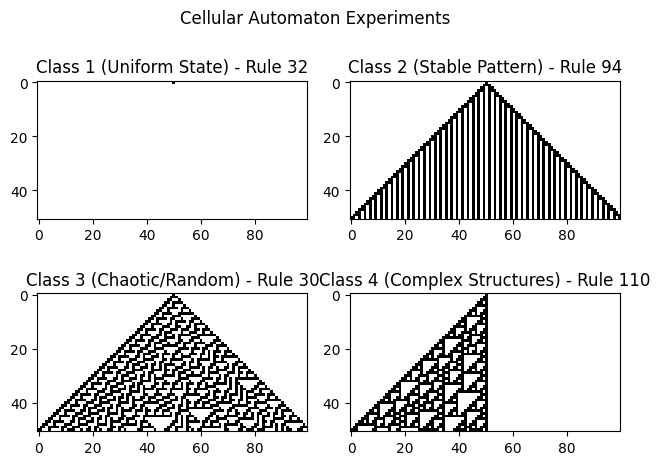

In [17]:
# Solution for Ex. 3 here...
def axes_layout(nrows=1, ncols=1, fig_title=None, **kwargs):
    """Layout nrows x ncols axes with sensible defaults. kwargs passed directly to `plt.subplots()`"""
    kwargs = {**dict(layout='tight'), **kwargs}
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
    if fig_title:
        fig.suptitle(fig_title)
    return fig, axes

def experiment(rule_number, n_cells=100, n_steps=50):
    """Simulate and visualize a 1D Cellular Automaton given a rule number."""
    rule = get_lookup_table(rule_number)  # Convert rule number to binary rule set
    ca = Cell1D(rule_number, single_centre_array(n_cells))  # Initialize CA
    ca.simulate(n_steps)  # Simulate CA for given steps
    return ca  # Return the simulated CA instance

# Define rules for each class
class_rules = {
    "Class 1 (Uniform State)": 32,
    "Class 2 (Stable Pattern)": 94,
    "Class 3 (Chaotic/Random)": 30,
    "Class 4 (Complex Structures)": 110
}

# Create a layout for the 2x2 grid
fig, axes = axes_layout(2, 2, fig_title='Cellular Automaton Experiments')

# Plot each cellular automaton in the defined layout
for ax, (class_name, rule) in zip(axes.flatten(), class_rules.items()):
    ca = experiment(rule)
    ca.draw(ax)  # Use the draw method to plot the CA
    ax.set_title(f"{class_name} - Rule {rule}")
plt.tight_layout()
plt.show()


#### Sample code for creating a 2x2 grid of plots

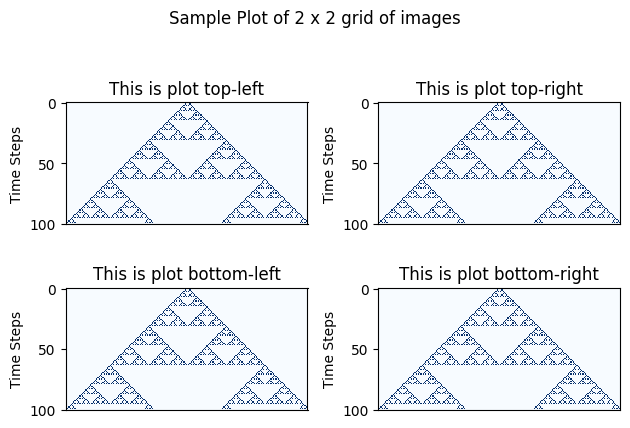

In [9]:
def axes_layout(nrows=1, ncols=1, fig_title=None, **kwargs):
    """ layout nrows x ncols axes with sensible defaults.  kwargs passed directly to `plt.subplots()`"""
    kwargs = {**dict(layout='tight'), **kwargs}
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
    if fig_title:
        fig.suptitle(fig_title)
    return axes

# Example: plot 4 plots in a 2x2 grid - plots are labelled so it's clear which is which.
axes = axes_layout(2, 2, fig_title='Sample Plot of 2 x 2 grid of images')
for ax, title in zip(axes.flat, ('top-left', 'top-right', 'bottom-left', 'bottom-right' )):
    plot_ca(ca_timesteps, axes=ax, title=f'This is plot {title}')

## Exercise 4:  Thought Experiments
Think about some of the questions that arise from this experiment.  Provide some concise answer that capture you thinking...
1. What is it about these experiments that requires computation?
Is there some other means by which we could conduct experiments like this?

2. What conclusions can you draw about the conditions under which complex behaviours can arise?
Do you think these conclusions are mostly intuitive or counter-intuitive?

3. What lessons might we take about studying complex phenomena in the real world from our study of elementary cellular automata?

### Answers
(concise, point-form -- there are no wrong answers, I'd just like to hear what you think)

1. **Complexity:** The CA can produce numerous outcomes just based on some simple initial states. Computation allows for quick interactions and the replica of numerous scenarios.
 **Visualization:** Computing results makes it easier to visualize patterns over time, helping us to see how a bunch of simple rules could lead to complex behaviour.
  **Scalability:** It is almost near to impossible to manually track changes in a large grid, so computation automates this process.

  There are a few other ways by whoch we could conduct experiments like this:

  **Manual Simulation:** One could draw each step manually, but it would a very tedious task and will be full of errors.
  
  **Simple Models:** Using simple models could also help. Manual analysis will be much easier if we could use smaller grids and fewer steps.

2. **Initial State:** The most important conclusion is that the initial state matters the most. Even minor variations can lead to significantly diferent behaviours.

 **Simple Rules:** Even simple rules can create complex patterns which means complexity doesn't requires much complicated rules.

 These conclusions are mostly intuitive. The idea that simple rules can lead to complex outcomes makes sense when we consider how many systems in nature operate similarly.

3. **Always Start Simple:** Many real-world problems might benefit from a simplifies approach to understanding their structure.

 **Look for Patterns:** Observing patterns in complex systems can reveal many rules that govern behaviour, similar to what we see in CA.

 **Explore Initial Conditions:** Just liek in CA, the initial conditions in real-world scenarios can significantly influence outcomes.

